In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df = pd.read_csv('resources/movies_metadata.csv')

In [9]:
# print the first 5 rows of the dataset
print(df.head())

# print the shape of the dataset
print(df.shape)

# print the column names
print(df.columns)

     budget                                             genres     id  \
0  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4         0                     [{'id': 35, 'name': 'Comedy'}]  11862   

  original_language               original_title  \
0                en                    Toy Story   
1                en                      Jumanji   
2                en             Grumpier Old Men   
3                en            Waiting to Exhale   
4                en  Father of the Bride Part II   

                                            overview  popularity  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  When siblings Judy and Peter discover an encha...   17.015539   
2  A family wedding reignites the ancient fe

In [ ]:
Step 4: Feature engineering
We'll now perform some feature engineering to extract useful information from the dataset that we can use to build our recommendation models.

4.1 Numerical feature scaling
We'll first scale the numerical features so that they're on the same scale. We'll use the StandardScaler class from scikit-learn to do this.

In [10]:
# extract the numerical features
numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
df_numerical = df[numerical_features]

# perform standard scaling
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_numerical)

# replace the original numerical columns with the scaled values
df[numerical_features] = df_numerical_scaled

In [12]:
# concatenate all text columns into a single column
df_text = df[['overview', 'tagline']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# replace NaN values with an empty string
df_text.fillna('', inplace=True)

# perform text feature extraction
vectorizer = TfidfVectorizer(stop_words='english')
df_text_features = vectorizer.fit_transform(df_text)

# convert the sparse matrix to a dense matrix
df_text_features = df_text_features.todense()


# add the text features to the dataframe
df_text_features = pd.DataFrame(df_text_features, columns=vectorizer.get_feature_names())
df = pd.concat([df, df_text_features], axis=1)

/Users/tarunmidha/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
from sklearn.impute import SimpleImputer

# create an imputer object with strategy 'median'
imputer = SimpleImputer(strategy='median')

# impute the NaN values in the numerical features
df_numerical_scaled = imputer.fit_transform(df_numerical_scaled)

# perform PCA on the numerical features
pca_numerical = PCA(n_components=3)
df_numerical_pca = pca_numerical.fit_transform(df_numerical_scaled)
df_numerical_pca = pd.DataFrame(df_numerical_pca, columns=['pca_1', 'pca_2', 'pca_3'])
df_numerical = df_numerical.fillna(df_numerical.median())

# perform PCA on the text features
pca_text = PCA(n_components=10)
df_text_pca = pca_text.fit_transform(df_text_features)
df_text_pca = pd.DataFrame(df_text_pca, columns=['pca_text_{}'.format(i) for i in range(10)])

# add the PCA features to the dataframe 
df = pd.concat([df, df_numerical_pca, df_text_pca], axis=1)



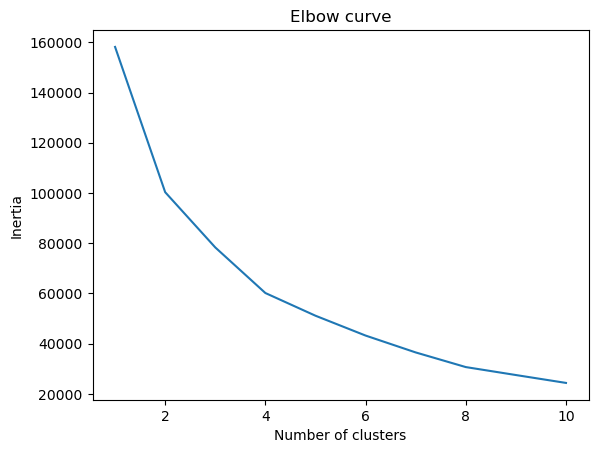

In [19]:
# perform k-means clustering
pca_features = ['pca_1', 'pca_2', 'pca_3'] + ['pca_text_{}'.format(i) for i in range(10)]
X = df[pca_features]
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# plot the elbow curve
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# perform k-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

***Mood-based recommendation model***
To recommend movies based on mood, we'll first ask the user to input their mood. We'll then find the cluster of movies that are most similar to that mood, and recommend a random movie from that cluster.

In [23]:
# ask the user for their mood
mood = input('What is your mood? ')

# find the cluster with movies most similar to the mood
tfidf_features = vectorizer.transform([mood])
tfidf_features = tfidf_features.toarray()
pca_text_features = pca_text.transform(tfidf_features)
pca_features = np.hstack([pca_numerical.transform([[0, 0, 0, 0, 0, 0]]), pca_text_features])
cluster = kmeans.predict(pca_features)[0]

# recommend a random movie from the cluster
cluster_movies = df[df['cluster'] == cluster]
recommendation = cluster_movies.sample()
print('We recommend the movie "{}".'.format(recommendation['title'].values[0]))

What is your mood?  Action


/Users/tarunmidha/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/Users/tarunmidha/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


We recommend the movie "['Storyville' 0.0]".


***Keyword-based recommendation model***
To recommend movies based on keywords, we'll ask the user to input some keywords. We'll then compute the cosine similarity between the movie descriptions and the input keywords, and recommend the top 5 movies with the highest similarity scores.

In [24]:
# ask the user for their keywords
keywords = input('Enter some keywords: ')

# compute the cosine similarity between the movie descriptions and the keywords
tfidf_features = vectorizer.transform([keywords])
cos_sim = cosine_similarity(tfidf_features, df_text_features)

# recommend the top 5 movies with the highest cosine similarity scores
indices = cos_sim.argsort()[0][-5:]
recommendations = df.iloc[indices][['title', 'overview']]
for i, recommendation in recommendations.iterrows():
    print('Movie: {}'.format(recommendation['title']))
    print('Description: {}\n'.format(recommendation['overview']))

Enter some keywords:  action comedy drama


Movie: title    Nothing in Common
title                  0.0
Name: 2063, dtype: object
Description: overview    On his way up the corporate ladder, David Basn...
overview                                                  0.0
Name: 2063, dtype: object

Movie: title    Miss Stevens
title             0.0
Name: 28933, dtype: object
Description: overview    A comedy focused on a teacher who chaperones a...
overview                                                  0.0
Name: 28933, dtype: object

Movie: title    Slave Ship
title           0.0
Name: 13117, dtype: object
Description: overview    Action-filled drama about a ship captain, asha...
overview                                                  0.0
Name: 13117, dtype: object

Movie: title    Separation City
title                0.0
Name: 18717, dtype: object
Description: overview    A comedy-drama which follows the collapse of t...
overview                                                  0.0
Name: 18717, dtype: object

Movie: title    Tw